<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D4_DeepLearning1/student/W3D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day4, Tutorial 1
# Deep Learning: Decoding Neural Responses
By Jorge A. Menendez; reviewed by Carsen Stringer, Roozbeh Farhoodi, and Madineh Sarvestani


#Tutorial Objectives
In this tutorial, we'll use deep learning to decode stimulus information from the responses of sensory neurons. Specifically, we'll look at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). Our task will be to decode the orientation of the presented stimulus from the responses of the whole population of neurons. We could do this in a number of ways, but here we'll use deep learning. Deep learning is particularly well-suited to this problem for a number of reasons:
* The data are very high-dimensional: the neural response to a stimulus is a ~20,000 dimensional vector. Many machine learning techniques fail in such high dimensions, but deep learning actually thrives in this regime as long as you have enough data (which we do here!).
* As you'll be able to see below, different neurons can respond quite differently to stimuli. This complex pattern of responses will, therefore, require non-linear methods to be decoded, which we can easily do with non-linear activation functions in deep networks.
* Deep learning architectures are highly flexible, meaning we can easily adapt the architecture of our decoding model to optimize decoding. Here, we'll focus on a single architecture, but you'll see that it can easily be modified with few changes to the code.

In this tutorial, we will learn how to:
* Build a deep feed-forward network using PyTorch
* Evaluate the network's outputs using PyTorch built-in loss functions
* Compute gradients of the loss with respect to each parameter of the network using automatic differentiation
* Implement stochastic gradient descent to optimize the network parameters

Video available at https://youtu.be/BXvfDj3AP_A


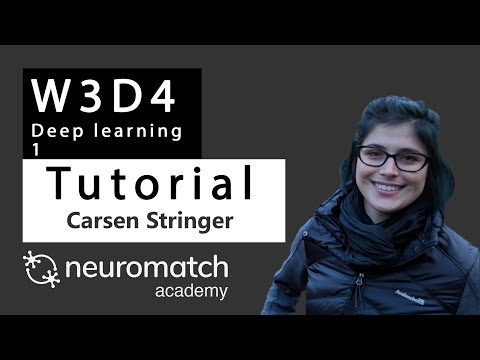

In [1]:
#@title Video: decoding from neural data & feed-forward network architectures and computation
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BXvfDj3AP_A", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
## Setup

**Don't forget to execute the hidden cells below!**

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
# @title Download data

# Download data from OSF
data_filename = 'mouseV1.npy'
if data_filename in os.listdir():
  print('data already downloaded!')
else:
  print('downloading data...')
  !wget -O mouseV1.npy https://osf.io/6g4nz/download

downloading data...
--2020-07-01 23:04:54--  https://osf.io/6g4nz/download
Resolving osf.io (osf.io)... 

35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.


HTTP request sent, awaiting response... 

302 FOUND
Location: https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/5edacf4208aad3008943c865?action=download&direct&version=1 [following]
--2020-07-01 23:04:55--  https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/5edacf4208aad3008943c865?action=download&direct&version=1
Resolving files.ca-1.osf.io (files.ca-1.osf.io)... 

35.241.38.243
Connecting to files.ca-1.osf.io (files.ca-1.osf.io)|35.241.38.243|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 867771933 (828M) [application/octet-stream]
Saving to: ‘mouseV1.npy’

mouseV1.npy           0%[                    ]       0  --.-KB/s               

mouseV1.npy           2%[                    ]  18.41M  91.7MB/s               

mouseV1.npy           5%[>                   ]  42.96M   107MB/s               

mouseV1.npy           9%[>                   ]  76.41M   127MB/s               

mouseV1.npy          13%[=>                  ] 110.22M   138MB/s               

mouseV1.npy          17%[==>                 ] 143.32M   143MB/s               

mouseV1.npy          21%[===>                ] 177.34M   148MB/s               

mouseV1.npy          24%[===>                ] 204.55M   146MB/s               

mouseV1.npy          28%[====>               ] 237.57M   148MB/s               

mouseV1.npy          32%[=====>              ] 271.70M   151MB/s               

mouseV1.npy          36%[======>             ] 302.95M   151MB/s               

mouseV1.npy          40%[=======>            ] 334.86M   152MB/s               

mouseV1.npy          44%[=======>            ] 367.19M   153MB/s               

mouseV1.npy          48%[========>           ] 401.65M   154MB/s               

mouseV1.npy          52%[=========>          ] 435.75M   156MB/s               

mouseV1.npy          56%[==========>         ] 468.67M   156MB/s    eta 2s     

mouseV1.npy          60%[===========>        ] 504.13M   161MB/s    eta 2s     

mouseV1.npy          65%[============>       ] 538.75M   164MB/s    eta 2s     

mouseV1.npy          69%[============>       ] 573.41M   166MB/s    eta 2s     

mouseV1.npy          73%[=============>      ] 607.66M   166MB/s    eta 2s     

mouseV1.npy          77%[==============>     ] 642.00M   166MB/s    eta 1s     

mouseV1.npy          81%[===============>    ] 671.05M   165MB/s    eta 1s     

mouseV1.npy          84%[===============>    ] 702.21M   165MB/s    eta 1s     

mouseV1.npy          87%[================>   ] 722.99M   162MB/s    eta 1s     

mouseV1.npy          90%[=================>  ] 746.17M   139MB/s    eta 1s     

mouseV1.npy          90%[=================>  ] 747.32M   113MB/s    eta 1s     

mouseV1.npy          91%[=================>  ] 758.13M   108MB/s    eta 1s     

mouseV1.npy          93%[=================>  ] 775.57M   105MB/s    eta 0s     

mouseV1.npy          98%[==================> ] 817.45M   108MB/s    eta 0s     

mouseV1.npy         100%[===================>] 827.57M   107MB/s    in 6.6s    

2020-07-01 23:05:02 (125 MB/s) - ‘mouseV1.npy’ saved [867771933/867771933]



In [4]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)


In [5]:
#@title Helper Functions

def load_data():
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in 
  Google Colab.

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in radians

  """
  data = np.load(data_filename, allow_pickle=True).item()

  # Neural responses
  resp = torch.tensor(data['resp'], dtype=torch.float32)
  
  # Stimuli
  stimuli = torch.tensor(data['stimuli'], dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector
  
  return resp, stimuli


def plot_data_matrix(X):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap

  """
  fig, ax = plt.subplots()

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')
  
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


class progress_bar():
  """Progress bar for displaying progress over neural network training

  Args:
    n_epochs (int): number of epochs that network will be trained for

  Attributes:
    bar (list of str): the current state of the progress bar
    counter (int): counter tracking the current number of epochs run
    n_epochs (int): total number of epochs to be run
  
  """
  
  def __init__(self, n_epochs):
    self.bar = ['|']
    for i in range(n_epochs):
        self.bar.append(' ')
    self.bar.append('|')
    self.counter = 0
    self.n_epochs = n_epochs
  
  def update(self):
    """Update the progress bar and print it"""
    self.counter += 1
    self.bar[self.counter] = '='
    print('%s     (epoch %i/%i complete)' % (''.join(self.bar), self.counter, self.n_epochs))

---
## Load and visualize data

In the next cell, we have provided code to load the data and plot the matrix `resp` of neural responses.

resp contains responses of 23589 neurons to 4598 stimuli


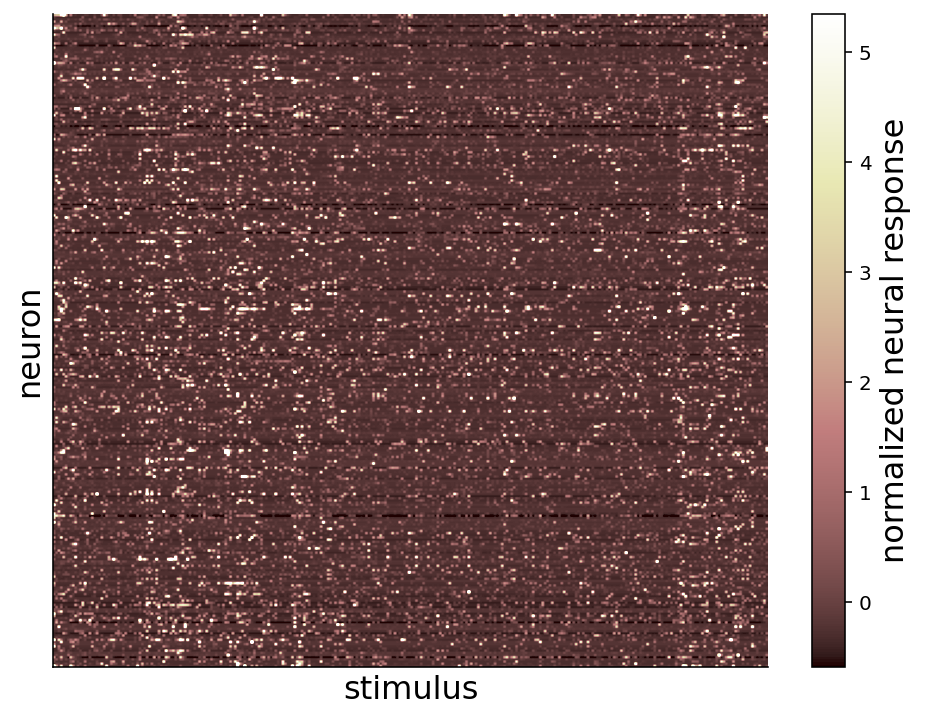

In [6]:
# Load data
resp, stimuli = load_data()
n_stimuli, n_neurons = resp.shape
print(f'resp contains responses of {n_neurons} neurons to {n_stimuli} stimuli')

# Visualize data matrix
plot_data_matrix(resp[:300, :300].T)  # plot responses of first 300 neurons to first 300 stimuli
plt.xlabel('stimulus')
plt.ylabel('neuron')
plt.show()

### Exercise 1

Plot the tuning curve of a single neuron. The tuning curve should show the responses of that neuron to each stimulus as a function of the stimulus orientation.

You'll need the following variables:
* `resp` contains the responses of every neuron to every stimulus. The $i$th column contains the responses of the $i$th neuron to each stimulus.
* `stimuli` contains the orientations of each stimulus

**Suggestions**
* convert the stimuli from radians to degrees to get a more interpretable $x$-axis

In [7]:
def plot_tuning():
  """Plot the tuning curve of a random neuron"""

  ################################################################################
  ## TO DO for students: sample a random neuron and plot its tuning curve
  # neuron_indx = ...  # pick random neuron
  # plt.plot(..., ..., '.')  # plot its responses as a function of stimulus orientation
  raise NotImplementedError("Student exercise: write code for plotting tuning curve")
  ################################################################################
  
  plt.title('neuron %i' % neuron_indx)
  plt.xlabel('stimulus orientation ($^o$)')
  plt.ylabel('neural response')
  plt.xticks(np.linspace(0, 360, 5))
  plt.show()

# plot_tuning()  # UNCOMMENT

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_2a11ec87.py)

*Example output:*

<img alt='Solution hint' align='left' width=502 height=409 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial1_Solution_2a11ec87_0.png>



---
## Building deep feed-forward networks with *PyTorch*

We'll now build a simple deep neural network that takes as input a vector of neural responses and outputs a single number representing the decoded stimulus orientation. Specifically, we'll build a deep network with one hidden layer.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^T$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], \\
    y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M],
\end{align}
where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$th stimulus. 

The $M$-dimensional vector $\mathbf{h}^{(n)}$ denotes the activations of the **hidden layer** of the network. The reason it is called hidden can be glimpsed from the schematic below, showing how the hidden layer is, in a sense, "hidden" from the input and output of the network. Deeper networks may have multiple hidden layers, but here we'll just focus on a single hidden layer. 

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

We have provided code below for building such a network in PyTorch, using the PyTorch `nn.Module` object class. It contains three key ingredients:

* `__init__()` method to initialize its parameters, like in any other Python class. In this case, it takes a single argument which specifies the number of units in the hidden layer.

* `nn.Linear()` modules, which are built-in PyTorch objects containing all the weights and biases for a given network layer. See [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) for documentation. It takes two arguments:
   * \# of inputs to that layer, and 
   * \# of outputs from that layer

  For the input layer, for example, we have:
   * \# of inputs = \# of neurons whose responses are to be decoded ($N$)
   * \# of outputs = \# of hidden layer units ($M$)
  
  PyTorch will initialize all weights and biases randomly.

* `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. We provide the code for doing this using the built-in PyTorch `nn.Linear()` objects.


In [9]:
#@title DeepNet
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer
  
  """

  def __init__(self, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_neurons, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_neurons. Can also be a tensor of shape p x n_neurons,
        containing p vectors of neural responses
    
    Returns:
      y (torch.Tensor): network outputs for each input provided in r. If 
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape p x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

We next provide code for running the deep network, i.e. for using the deep network to decode stimulus orientation from a vector of neural responses.

An important thing to note in this code snippet is the `.detach()` method. The PyTorch `nn.Module` class is special in that, behind the scenes, each of the variables linked to it are linked to each other in a computational graph, for the purposes of automatic differentiation (which will be discussed below). As a result, if you want to do anything that is not a `torch` operation to the parameters or outputs of an `nn.Module` class, you'll need to first "detach" it from its computational graph. This is what the `.detach()` method does. You'll see in this code snippet we need to call it on the outputs of the network so that we can pass it through the `np.rad2deg()` function.

In [10]:
# Initialize a deep network with M=200 hidden units
net = DeepNet(200)

# Decode stimulus orientation from neural responses to the first stimulus 
# in the data set. Note that the output of the network will be nonsense 
# as its weights have been initialized randomly.
istim = 0  # index of first stimulus
r = resp[istim]  # neural responses to this stimulus
out = net(r)  # compute output from network using forward() method
ori_decode = np.rad2deg(out.detach())  # decoded orientation, in degrees -- need to use .detach() so that the torch.Tensor can be treated as a numpy array
ori_true = np.rad2deg(stimuli[istim])  # true stimulus orientation, in degrees

print('decoded orientation: %.2f degrees' % ori_decode)
print('true orientation: %.2f degrees' % ori_true)

decoded orientation: -32.62 degrees
true orientation: 150.13 degrees


Note that the deep network we constructed above comprises solely **linear** operations on each layer: each layer is just a weighted sum of the elements in the previous layer. We'll next incorporate a certain class of **non-linear** operations. Using non-linear layer-to-layer transformations, in fact, allows deep networks to perform much more complex computations, which is why non-linearities are always used in practice.

### Exercise 2

Create a new class `DeepNetReLU` by modifying our above deep network model to implement a non-linear transformation from the input layer to the hidden layer. In other words, modify it so that the hidden layer activations are given by
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is some non-linear function, referred to as the **activation function**. We'll use linear rectification:
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}
which can be implemented in PyTorch using `torch.relu()`. Hidden layers with this activation function are typically referred to as "**Re**ctified **L**inear **U**nits", or **ReLU**'s.

**Hint**: you only need to modify the `forward()` method of the above `DeepNet()` class.


In [11]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    ##############################################################
    ## TO DO for students: initialize network weights using nn.Linear() objects
    raise NotImplementedError("Student exercise: write code for initializing deep network")
    ##############################################################

  def forward(self, r):
    ##############################################################
    ## TO DO for students: write code for computing network output, using a
    ## rectified linear activation function for the hidden units
    raise NotImplementedError("Student exercise: write code for computing network output")
    ##############################################################

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_48c0b82d.py)



Video available at https://youtu.be/rx8d2EkV1Mg


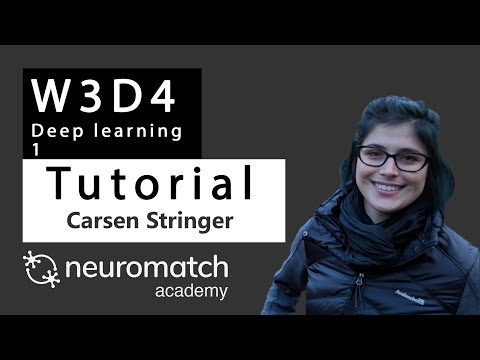

In [13]:
#@title Video: loss functions & SGD
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="rx8d2EkV1Mg", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
## Evaluating loss functions

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense: the decoded stimulus orientation is nowhere close to the true stimulus orientation. We'll shortly write some code to change these weights so that the network does a better job of decoding.

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the **squared error**
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true stimulus orientation. When the decoded stimulus orientation is far from the true stimulus orientation, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is at decoding stimulus orientation.

PyTorch actually carries with it a number of built-in loss functions. The one corresponding to squared error is called `nn.MSELoss()`. This will take as arguments a number of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

We provide code below evaluating the mean squared error of our linear deep network for the neural responses to the first 100 stimuli.

In [14]:
# PyTorch mean squared error loss function
loss_fn = nn.MSELoss()

# Evaluate mean squared error on neural responses
# to first 100 stimuli
istim = np.arange(100)  # indeces of first 100 stimuli
out = net(resp[istim])  # decoded stimulus orientations
ori = stimuli[istim]  # true stimulus orientations
print('mean squared error: %.2f' % loss_fn(out, ori))

mean squared error: 12.17


### Exercise 3

Write a function that will evaluate the mean squared error for a given set of neural responses. Use the  initialized `loss_fn` above to compute the mean squared error.

Then, initialize a deep network with $M=20$ rectified linear units in the hidden layer, and use your function to evaluate its mean squared error on population responses to 100 random stimuli.

In [15]:
######################################################################
## TO DO for students:
##   - initialize a deep network with one hidden layer of 20 rectified
##     linear units, using the above implemented DeepNetReLU() class
##   - pick 100 random stimuli
##   - use the network to decode stimulus orientation from responses to 
##     these stimuli
##   - evaluate the mean squared error using loss_fn()
# net = ...  # initialize deep network, using DeepNetReLU()
# istim = ...  # indices of 100 random stimuli
# out = ...  # use network to decode orientation from neural responses
# loss = ...  # evaluate mean squared error using loss_fn()
# print('mean squared error: %.2f' % loss)
######################################################################

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_70ebabdf.py)



---
## Optimization with stochastic gradient descent

Our goal is to modify the weights to make the mean squared error loss $L$ as small as possible over the whole data set. To do this, we'll use the **stochastic gradient descent (SGD)** algorithm, which consists of iterating four simple steps:
1. **Randomly sample a *mini-batch* of training data**. This is only strictly necessary when the full data set is too big to pass through the network all at once. That said, using mini-batches turns out to also help avoid overfitting.
2. **Evaluate the loss** at this mini-batch
3. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code: if the loss is stored in a variable `loss`, all you need to do is run
```
loss.backward()
```
PyTorch will then compute the gradients of this quantity with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and store them behind the scenes.
4. **Update the network weights** by descending the gradient. In Pytorch, we can do this with one line of code by using built-in optimizers. The SGD optimizer is called `optim.SGD` (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)), and takes as an argument 
  * the parameters to be updated
  * the learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, one would use
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  To update each of these parameters, we then need only call the `.step()` method of this optimizer:
  ```
  optimizer.step()
  ```
  This single line of code will execute the SGD updates for each parameter given to the optimizer when it was initialized. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

For the mathematical details of the SGD algorithm, see the appendix.

### Exercise 4

1. Complete the function `train()` that optimizes the weights of a given network with stochastic gradient descent on some given training data. We've provided most of the code for iterating over steps 1-4 listed above. The only piece left for you to complete is step 2: evaluating the loss $L$ at the current mini-batch.

  **Hint:** you already wrote code for computing the MSE term $L_{MSE}$ in the previous exercise, and you can use the `L2penalty()` function to evaluate the regularization term $\mathcal{R}_{L2}$. Don't forget to mutiply the regularization term by the regularization weight `gamma` before summing it with the MSE!

  **Note:** this function has two nested loops. The outer loop is over epochs. The inner loop iterates the SGD steps 1-4 outlined above over random mini-batches within each epoch. (cf. appendix)

2. Initialize a deep network with one hidden layer of 20 rectified linear units and use this function to train it on some training data (with the given default SGD parameters).

  **Hint:** use your `DeepNetReLU()` class to initialize the deep network.

Note that SGD is essentially an algorithm for fitting the network's parameters to the given training data. Selecting this training data is thus crucial for ensuring that the optimized parameters **generalize** to unseen data they weren't trained on. In our case, for example, we want to make sure that our trained network is good at decoding stimulus orientations from neural responses to any orientation, not just those in our data set.

To ensure this, we will split up the full data set into a **training set** and a **test set**. We'll use the training set for optimizing the parameters with SGD, and then evaluate how good the optimized parameters are by using the trained network to decode stimulus orientations from neural responses in the test set. Good decoding performance on this test set should then be indicative of good decoding performance on the neurons' responses to any other stimulus orientation. This procedure is commonly used in machine learning (not just in deep learning)and is typically referred to as **cross-validation**.

When using this for SGD, it is also worth noting that the random subsampling of our data used to build the training set induces a certain amount of stochasticity into our gradient descent algorithm, which will help avoid potential local minima.


In [17]:
def train(net, train_data, train_labels):
  """Run stochastic gradient descent for a given network
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data

  """

  # Set SGD hyperparameters
  learning_rate = 1e-3  # learning rate for SGD
  n_epochs = 10  # number of epochs to run SGD
  batch_size = 250  # number of data points in each mini-batch

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save MSE at each iteration
  train_mse = []

  # Progress bar to track progress
  pbar = progress_bar(n_epochs)

  # Loop over epochs
  for i in range(n_epochs):

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches

    # Loop over mini-batches
    for r, ori in zip(minibatch_data, minibatch_labels):

      # Evaluate mean squared error loss
      ######################################################################
      ## TO DO for students: evaluate loss at current mini-batch
      # out = ...  # use network to decode orientation from neural responses in this minibatch
      # loss = ...  # evaluate mean squared error for this minibatch
      raise NotImplementedError("Student exercise: write code for evaluating loss at current mini-batch")
      ######################################################################

      # Store current mean squared error
      train_mse.append(loss.item())  # .item() transforms the tensor to a scalar and does .detach() for us

      # Compute gradients
      optimizer.zero_grad()  # clear gradients
      loss.backward()

      # Update weights
      optimizer.step()

    # Track progress
    pbar.update()
  
  # Plot the loss
  plt.plot(train_mse)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of stochastic gradient descent')
  plt.ylabel('mean squared error\non training data')
  plt.show()

# Split data into training set and testing set
n_train = int(0.75 * n_stimuli)  # putting 75% of data into training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set

# Initialize network and train it on training set
######################################################################
## TO DO for students: initialize deep network and train it on training set
# net = ...  # use M=20 hidden units
# train(net, ..., ...)
######################################################################

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_3455cc67.py)

*Example output:*

<img alt='Solution hint' align='left' width=528 height=389 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial1_Solution_3455cc67_6.png>



### Exercise 5

1. Complete the function `test()` that decodes stimulus orientations from a given set of test data and plots these against the true stimulus orientations, in degrees.
2. Use this function to evaluate the network trained in the previous exercise on data from the test set, indexed by `itest`.

**Hint:** don't forget to use `.detach()` to do any plotting or `numpy` operations on the network output

In [19]:
def test(net, test_data, test_labels):
  """Decode stimulus orientation from neural responses in test data and plot
  against the true stimulus orientations, in degrees

  Args:
    net (nn.Module): deep network to use to decode stimulus orientation
    test_data (torch.Tensor): n_test x n_neurons tensor with neural
      responses to decode
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of test_data, in radians

  """

  ########################################################################
  ## TO DO for students: decode stimulus orientation from neural responses in test_data
  ## and plot against true stimulus orientations in test_labels
  # out = ...  # decode stimulus orientation for each population response in test set
  # ori_decode = ...  # transform from radians to degrees
  # ori_true = ...  # true stimulus orientations, in degrees
  raise NotImplementedError("Student exercise: write code for decoding stimulus orientation from neural responses in test set")
  ########################################################################

  # Plot
  plt.plot(ori_true, ori_decode, '.')  # plot true orientation vs decoded orientation
  plt.xlabel('true stimulus orientation ($^o$)')
  plt.ylabel('decoded stimulus orientation ($^o$)')
  axticks = np.linspace(0, 360, 5)
  plt.xticks(axticks)
  plt.yticks(axticks)
  plt.show()

###############################################################################
## TO DO for students: use test() function to evaluate network trained in previous exercise
## on the test set
# test(net, ..., ...)
###############################################################################

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_a7fbc2de.py)

*Example output:*

<img alt='Solution hint' align='left' width=520 height=390 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial1_Solution_a7fbc2de_0.png>



---
## Model criticism

Let's now take a step back and think about how our model is succeeding/failing and how to improve it.

### Exercise 6

1. Complete the function `decoding_error()` that computes the decoding error (decoded stimulus orientation minus true stimulus orientation, in degrees) on a given set of test data and plots it as a function of the true stimulus orientation.

2. Use this function to evaluate and plot the decoding error of the network trained in the previous exercise on data from the test set, indexed by `itest`.

3. Interpret what you see. Some questions to think about:
  * Are some stimulus orientations harder to decode than others?
  * If so, in what sense? Are the decoded orientations for these stimuli more variable and/or are they biased?
  * Can you explain this variability/bias? What makes these stimulus orientations different from the others?
  * Can you think of a way to modify the deep network in order to avoid this?

In [21]:
def decoding_error(net, test_data, test_labels):
  """Plot decoding error as a function of true stimulus orientation, in degrees

  Args:
    net (nn.Module): deep network to use to decode stimulus orientation
    test_data (torch.Tensor): n_test x n_neurons tensor with neural
      responses to decode
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of test_data, in radians

  """

  ########################################################################
  ## TO DO for students: compute and plot the decoding error
  # out = ...  # decode stimulus orientation for each population response in test set
  # ori_decode = ...  # transform from radians to degrees
  # ori_true = ...  # true stimulus orientations, in degrees
  # error = ...  # decoding error, in degrees
  # plt.plot(..., ..., '.')   # plot decoding error as a function of true orientation
  raise NotImplementedError("Student exercise: write code for computing and plotting the decoding error")
  ########################################################################

  plt.xlabel('true stimulus orientation ($^o$)')
  plt.ylabel('decoding error ($^o$)')
  plt.xticks(np.linspace(0, 360, 5))
  plt.yticks(np.linspace(-360, 360, 9))
  plt.show()

###############################################################################
## TO DO for students: use decoding_error() function to plot decoding error on the test set
## for the network trained above
# decoding_error(net, ..., ...)
###############################################################################

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D4_DeepLearning1/solutions/W3D4_Tutorial1_Solution_8af20f38.py)

*Example output:*

<img alt='Solution hint' align='left' width=527 height=395 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D4_DeepLearning1/static/W3D4_Tutorial1_Solution_8af20f38_0.png>



---
## Summary

We have now covered a number of common and powerful techniques for applying deep learning to decoding from neural data, some of which are common to almost any machine learning problem:
* Building and training neural network models with **PyTorch and automatic differentiation**
* Choosing and evaluating **loss functions**
* Implementing **stochastic gradient descent** by iterating over random **mini-batches** of training data
* Testing a trained model on unseen data by splitting the data into a **training set and test set**

---
# Appendix

## Stochastic gradient descent

Here we provide a more detailed explanation of the **stochastic gradient descent (SGD) algorithm** as applied to our decoding problem, and its implementation in PyTorch. 

This algorithm consists of iterating four simple steps:
1. **Randomly sample a *mini-batch* of training data.** In our case, that means randomly sampling a set of neural response vectors $\mathbf{r}^{(1)}, \mathbf{r}^{(2)}, \ldots, \mathbf{r}^{(P)}$ and corresponding stimulus orientations $\tilde{y}^{(1)}, \tilde{y}^{(2)}, \ldots, \tilde{y}^{(P)}$. 
2. **Evaluate the loss** at this mini-batch. For a mean squared error loss, this is given by
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P (y^{(n)} - \tilde{y}^{(n)})^2
\end{equation}
where recall that $y^{(n)}$ denotes the stimulus orientation decoded from the population response $\mathbf{r}^{(n)}$ to the $n$th stimulus, and $\tilde{y}^{(n)}$ is the true orientation of this stimulus.
3. **Compute the gradient of the loss** with respect to each of the network weights. In our case, that entails computing the quantities
\begin{equation}
    \frac{\partial L}{\partial \mathbf{W}^{in}}, \frac{\partial L}{\partial \mathbf{b}^{in}}, \frac{\partial L}{\partial \mathbf{W}^{out}}, \frac{\partial L}{\partial \mathbf{b}^{out}}
\end{equation}
Usually, this would require lots of math in order to derive these gradients, and lots of code to compute them. But this is where PyTorch comes to the rescue! Using a cool technique called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), PyTorch will calculate these gradients automatically for you. If the loss is stored in a variable `loss`, all you need to do is run
```
loss.backward()
```
PyTorch will then compute the gradient of this quantity with respect to each network parameter. These are computed and stored behind the scenes, and can be accessed through the `.grad` attribute of each of the network's parameters. But, as you'll see next, we won't even need to.

4. **Update the network weights** by descending the gradient:
\begin{align}
    \mathbf{W}^{in} &\leftarrow \mathbf{W}^{in} - \alpha \frac{\partial L}{\partial \mathbf{W}^{in}} \\
    \mathbf{b}^{in} &\leftarrow \mathbf{b}^{in} - \alpha \frac{\partial L}{\partial \mathbf{b}^{in}} \\
    \mathbf{W}^{out} &\leftarrow \mathbf{W}^{out} - \alpha \frac{\partial L}{\partial \mathbf{W}^{out}} \\
    \mathbf{b}^{out} &\leftarrow \mathbf{b}^{out} - \alpha \frac{\partial L}{\partial \mathbf{b}^{out}}
\end{align}
where $\alpha$ is called the **learning rate**. This **hyperparameter** of the SGD algorithm controls how far we descend the gradient on each iteration. It should be as large as possible so that fewer iterations are needed, but not too large so that the parameter updates can't skip over minima in the loss landscape. 

  In Pytorch we can implement all of these updates with just a single line of code. We first construct an SGD optimizer using the `optim.SGD` class (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)), and tell it which parameters to update and what learning rate to use. For example, to optimize the parameters of a network `net` using a learning rate of .001, we construct an SGD optimizer as follows
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where the method `net.parameters()` returns all of the parameters (i.e. weights and biases) in `net`. To update each of these parameters, we then need only call the `.step()` method of this optimizer:
  ```
  optimizer.step()
  ```
  This single line of code will execute each of the updates written above. Moreover, for more complicated networks with more layers and more parameters, this single line of code will suffice to update *all* of its parameters according to the analogous gradient descent equations.

## Epochs and mini-batches

Note that our above implementation of SGD contains two nested loops. The inner loop is over mini-batches, implementing steps 1-4 above. But take a close look at exactly how these mini-batches are being randomly sampled. Rather than sampling a totally random mini-batch of training data each iteration, we split up the full training data into non-overlapping mini-batches to ensure that these mini-batches will cover the whole training data set. Each time we loop over all the mini-batches covering the training data set is called an **epoch**. The outer loop is over **epochs**: we loop over the entire training data set `n_epoch` times.